Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 798ms/step - accuracy: 0.5021 - loss: 0.7252 - val_accuracy: 0.6049 - val_loss: 0.6785
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 134s 725ms/step - accuracy: 0.5948 - loss: 0.6644 - val_accuracy: 0.6066 - val_loss: 0.6777
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 727ms/step - accuracy: 0.6433 - loss: 0.6253 - val_accuracy: 0.6500 - val_loss: 0.6302
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 804ms/step - accuracy: 0.6974 - loss: 0.5809 - val_accuracy: 0.6423 - val_loss: 0.6654
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 810ms/step - accuracy: 0.7434 - loss: 0.5199 - val_accuracy: 0.7184 - val_loss: 0.6069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━

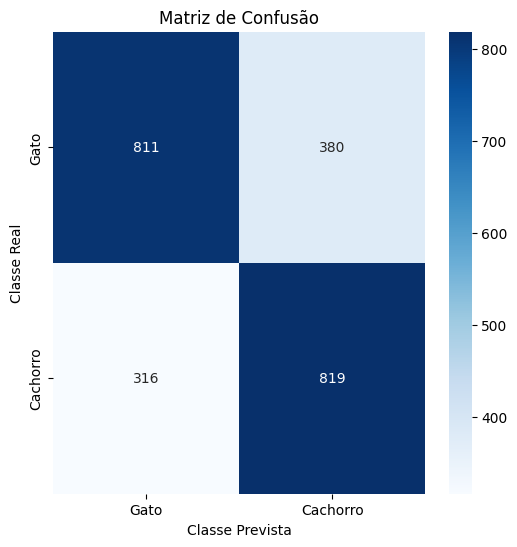


----Resultado das métricas----
Sensibilidade: 0.72
Especificidade: 0.68
Precisão: 0.68
F-score: 0.70
Acurácia: 0.70


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models

# carrega o dataset Cats vs Dogs
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

# divide o dataset em 'train', 'validation' e 'test'
train_dataset = dataset['train']

# definir proporções, pois esse dataset não tem um conjunto test
val_size = int(0.1 * info.splits['train'].num_examples)  # 10% para validação
test_size = int(0.1 * info.splits['train'].num_examples)  # 10% para teste

# cria os conjuntos de treino, validação e teste
train_dataset = train_dataset.skip(val_size + test_size)  # restante será treino
validation_dataset = dataset['train'].take(val_size)  # pega os primeiros para validação
test_dataset = dataset['train'].skip(val_size).take(test_size)  # pega os próximos para teste

# reduzindo o número de amostras para acelerar o processamento, pois antes estava passando de 2h
train_dataset = train_dataset.take(3000)

# pré-processamento das imagens
def preprocess_image(image, label):
    image = tf.image.resize(image, (100, 100))  # Reduzindo a resolução
    image = image / 255.0  # Normaliza as imagens para o intervalo [0, 1]
    return image, label

# aplica o pré-processamento
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
validation_dataset = validation_dataset.map(preprocess_image).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

# construir o modelo CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compila o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# treina o modelo. Coloquei poucas epocas para reduzir o tempo de compilação
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

# faz previsões
y_true, y_pred = [], []

for image, label in test_dataset:
    y_true.extend(label.numpy())
    y_pred.extend(model.predict(image).flatten())

# converte as previsões para 0 ou 1
y_pred = (np.array(y_pred) > 0.5).astype(int)
y_true = np.array(y_true)

# calcula a matriz de confusão
con_mat = confusion_matrix(y_true, y_pred)

# cria a matriz de confusão
con_mat_df = pd.DataFrame(con_mat, index=["Gato", "Cachorro"], columns=["Gato", "Cachorro"])
plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.title('Matriz de Confusão')
plt.show()

# calcula métricas
VP = con_mat[1, 1]
VN = con_mat[0, 0]
FP = con_mat[0, 1]
FN = con_mat[1, 0]

sensibilidade = VP / (VP + FN)
especificidade = VN / (FP + VN)
precisao = VP / (VP + FP)
f_score = 2 * (precisao * sensibilidade) / (precisao + sensibilidade)
acuracia = (VP + VN) / (VP + VN + FP + FN)

# Exibe os resultados
print('\n----Resultado das métricas----')
print(f'Sensibilidade: {sensibilidade:.2f}')
print(f'Especificidade: {especificidade:.2f}')
print(f'Precisão: {precisao:.2f}')
print(f'F-score: {f_score:.2f}')
print(f'Acurácia: {acuracia:.2f}')
